# RFM Anaysis and Customer Segmentation
Recency: How recently did the customer purchase? (Lower days = better)<br>
Frequency: How often do they purchase? (Higher count = better) <br>
Monetary: How much do they spend? (Higher sum = better) <br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from typing import Dict, List
import squarify
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes import GammaGammaFitter

In [3]:
# Load the cleaned data
df= pd.read_csv('../data/processed/master_data.csv', parse_dates=['InvoiceDate'])
df = df.copy()
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice,InvoiceMonth,DayOfWeek,Hour,CohortMonth,CohortIndex
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.40,2009-12,Tuesday,7,2009-12,1
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.00,2009-12,Tuesday,7,2009-12,1
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.00,2009-12,Tuesday,7,2009-12,1
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",27,2009-12-01 07:45:00,2.10,13085,United Kingdom,56.70,2009-12,Tuesday,7,2009-12,1
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,30.00,2009-12,Tuesday,7,2009-12,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
765599,580501,23284,DOORMAT KEEP CALM AND COME IN,2,2011-12-04 13:00:00,7.50,14546,United Kingdom,15.00,2011-12,Sunday,13,2009-12,25
765600,580501,22507,MEMO BOARD RETROSPOT DESIGN,3,2011-12-04 13:00:00,4.95,14546,United Kingdom,14.85,2011-12,Sunday,13,2009-12,25
765601,580502,22469,HEART OF WICKER SMALL,3,2011-12-04 13:15:00,1.65,16931,United Kingdom,4.95,2011-12,Sunday,13,2010-11,14
765602,580502,23489,VINTAGE BELLS GARLAND,2,2011-12-04 13:15:00,2.89,16931,United Kingdom,5.78,2011-12,Sunday,13,2010-11,14


In [4]:
def calculate_rfm_metrics(df: pd.DataFrame) -> pd.DataFrame:
    """Calculates the core Recency, Frequency, and Monetary metrics for each customer.

    Args:
        df: DataFrame with transactional data, including 'CustomerID', 'InvoiceDate', 
            'Invoice', and 'TotalPrice'.

    Returns:
        DataFrame with CustomerID as the index and Recency, Frequency, and Monetary columns.
    """
    snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
    
    rfm_metrics = df.groupby('Customer ID').agg({
        'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
        'Invoice': 'nunique',
        'TotalPrice': 'sum'
    }).rename(columns={
        'InvoiceDate': 'Recency',
        'Invoice': 'Frequency',
        'TotalPrice': 'Monetary'
    })
    
    return rfm_metrics

In [5]:
def calculate_rfm_scores(rfm_df: pd.DataFrame) -> pd.DataFrame:
    """Assigns quintile scores (1-5) to the R, F, and M metrics.

    Args:
        rfm_df: DataFrame containing Recency, Frequency, and Monetary columns.

    Returns:
        The input DataFrame with added 'R_Score', 'F_Score', and 'M_Score' columns.
    """
    rfm_df['R_Score'] = pd.qcut(rfm_df['Recency'], 5, labels=[5, 4, 3, 2, 1])
    rfm_df['F_Score'] = pd.qcut(rfm_df['Frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
    rfm_df['M_Score'] = pd.qcut(rfm_df['Monetary'], 5, labels=[1, 2, 3, 4, 5])
    
    return rfm_df

In [6]:
def assign_customer_segments(rfm_df: pd.DataFrame, segment_map: Dict[str, str]) -> pd.DataFrame:
    """Assigns a segment name based on R and F scores.

    Args:
        rfm_df: DataFrame containing 'R_Score' and 'F_Score' columns.
        segment_map: A dictionary defining the mapping from RF scores to segment names.

    Returns:
        The input DataFrame with an added 'Segment' column.
    """
    rfm_df['RF_Score'] = rfm_df['R_Score'].astype(str) + rfm_df['F_Score'].astype(str)
    rfm_df['Segment'] = rfm_df['RF_Score'].replace(segment_map, regex=True)
    
    return rfm_df

In [7]:
def create_region_aware_customer_segments(transaction_df: pd.DataFrame) -> pd.DataFrame:
    """
    Orchestrates a region-aware RFM analysis to handle geographic skew.
    """
    print("Starting Region-Aware RFM Segmentation")

    # Split data by region
    df_uk = transaction_df[transaction_df['Country'] == 'United Kingdom'].copy()
    df_row = transaction_df[transaction_df['Country'] != 'United Kingdom'].copy()
    print(f"Split data into UK ({len(df_uk)} rows) and RoW ({len(df_row)} rows).")

    # RFM metrics for each region
    rfm_uk_metrics = calculate_rfm_metrics(df_uk)
    rfm_row_metrics = calculate_rfm_metrics(df_row)
    print("Calculated RFM metrics for each region.")

    # RFM scores for each region
    rfm_uk_scored = calculate_rfm_scores(rfm_uk_metrics)
    rfm_row_scored = calculate_rfm_scores(rfm_row_metrics)
    print("Calculated RFM scores independently for each region.")

    #Combine the two scored dataframes
    rfm_combined_scored = pd.concat([rfm_uk_scored, rfm_row_scored])
    print("Recombined regional data after scoring.")

    # Assign final segments
    rfm_final = assign_customer_segments(rfm_combined_scored, SEGMENTATION_MAP)
    
    print("\nRFM Analysis Complete.")
    return rfm_final


In [8]:
# segmentation logic as a configuration constant
SEGMENTATION_MAP = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At-Risk',
    r'[1-2]5': 'Cannot Lose',
    r'3[1-2]': 'About to Sleep',
    r'33': 'Need Attention',
    r'[3-4][4-5]': 'Loyal Customers',
    r'41': 'Promising',
    r'51': 'New Customers',
    r'[4-5][2-3]': 'Potential Loyalists',
    r'5[4-5]': 'Champions'
}

In [9]:
print("Executing the full region-aware pipeline")
rfm_final_df = create_region_aware_customer_segments(df)

print("\nFinal Segmented DataFrame Head")
display(rfm_final_df.head())

Executing the full region-aware pipeline
Starting Region-Aware RFM Segmentation
Split data into UK (689531 rows) and RoW (76073 rows).
Calculated RFM metrics for each region.
Calculated RFM scores independently for each region.
Recombined regional data after scoring.

RFM Analysis Complete.

Final Segmented DataFrame Head


,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RF_Score,Segment
Customer ID,,,,,,,,
12346,321,12,400.94,2,5,2,25,Cannot Lose
12608,400,1,258.23,2,1,2,21,Hibernating
12745,482,2,614.85,1,2,3,12,Hibernating
12746,536,1,253.65,1,1,2,11,Hibernating
12747,17,25,7503.23,5,5,5,55,Champions


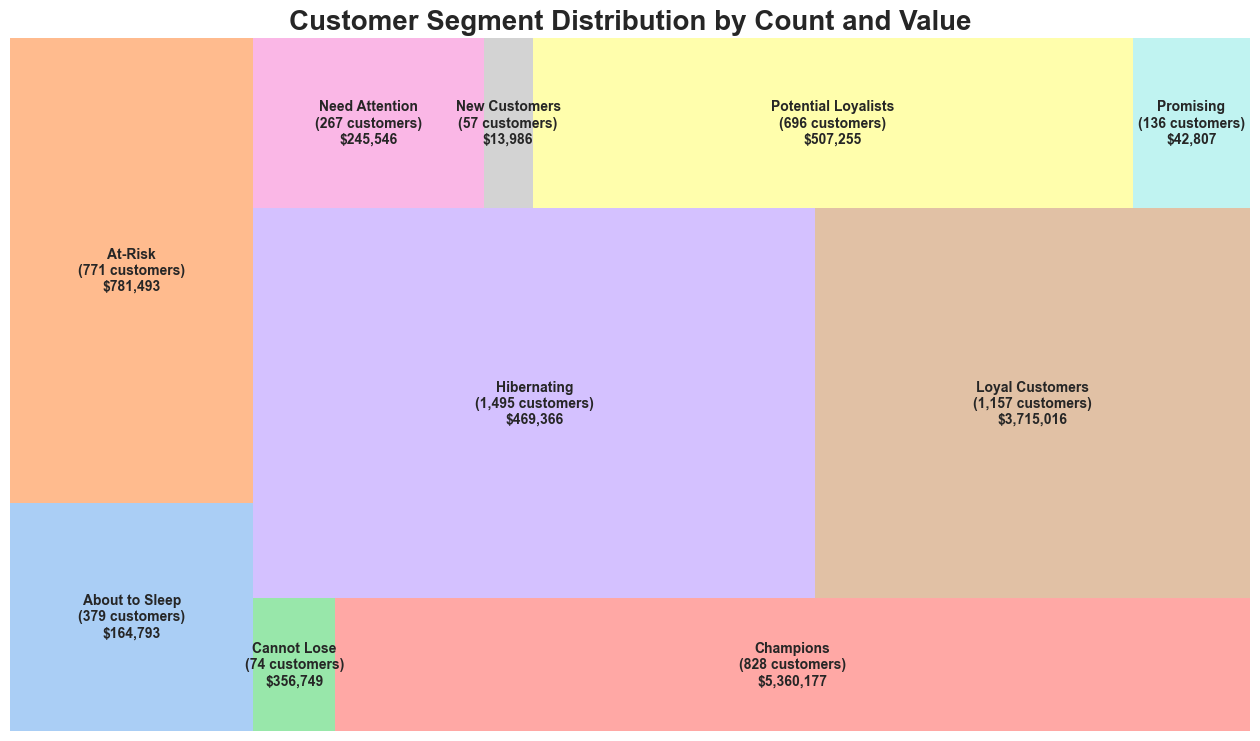

In [10]:
# Visualize Customer Segments with a Treemap
# Aggregate data for the treemap
# Group by segment and calculate the total monetary value and the number of customers in each segment
segment_analysis = rfm_final_df.groupby('Segment').agg(
    TotalMonetary=('Monetary', 'sum'),
    CustomerCount=('Monetary', 'count')
).reset_index()

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(16, 9))

# Labels for the treemap boxes
labels = [f'{row.Segment}\n({row.CustomerCount:,} customers)\n${row.TotalMonetary:,.0f}' 
          for index, row in segment_analysis.iterrows()]

# Squarify to plot the treemap
squarify.plot(sizes=segment_analysis['CustomerCount'], 
              label=labels, 
              alpha=0.9, 
              color=sns.color_palette("pastel", len(segment_analysis)),
              text_kwargs={'fontsize': 10, 'fontweight': 'bold'})

plt.title('Customer Segment Distribution by Count and Value', fontsize=20, fontweight='bold')
plt.axis('off')
plt.show()

#### Inference
This analysis confirms a stark Pareto Principle in customer base: a small elite of customers drives the vast majority of revenue.

1. The Power Core: "Champions" are the engine of the business. This group, representing just 14% of customers, generates an incredible $5.4 million in revenue. Together with "Loyal Customers," these top two segments account for over 75% of your total revenue.

2. The Revenue at Risk: The "At-Risk" and "Cannot Lose" segments represent over $1.1 million in revenue from customers who are drifting away. This is most immediate opportunity for revenue recovery.

3. The Long Tail: The "Hibernating" segment is largest by customer count (1,495 customers) but has a low total monetary value, representing a classic long tail of inactive users.

##### Strategic Conclusion:<br>
Business thrives on its high-value customers. The top priorities must be implementing a VIP strategy to retain your "Champions" and launching targeted re-engagement campaigns to win back the significant revenue in the "At-Risk" segments.

In [12]:
# Customer Lifetime Value (LTV) Estimation
# Prepare Data for Lifetimes Model

clv_data = df[['Customer ID', 'InvoiceDate', 'TotalPrice']]

# transform the data into the required summary format
ltv_summary = summary_data_from_transaction_data(
    clv_data,
    customer_id_col='Customer ID',
    datetime_col='InvoiceDate',
    monetary_value_col='TotalPrice',
    observation_period_end=df['InvoiceDate'].max()
)

print("Data Prepared for CLV Modeling")
# We filter out customers who have not made any repeat purchases (frequency = 0)
# as their future behavior cannot be predicted with this model.
ltv_summary = ltv_summary[ltv_summary['frequency'] > 0]

print(f"Number of repeat customers to be modeled: {len(ltv_summary)}")
display(ltv_summary.head())

Data Prepared for CLV Modeling
Number of repeat customers to be modeled: 4148


,frequency,recency,T,monetary_value
Customer ID,,,,
12346,7.0,400.0,720.0,44.4200
12347,6.0,365.0,399.0,608.7700
12348,4.0,363.0,433.0,122.5175
12349,2.0,571.0,584.0,1205.4850
12352,8.0,356.0,387.0,192.9050


BG/NBD Model Fitted
<lifetimes.BetaGeoFitter: fitted with 4148 subjects, a: 0.11, alpha: 106.58, b: 1.15, r: 1.55>


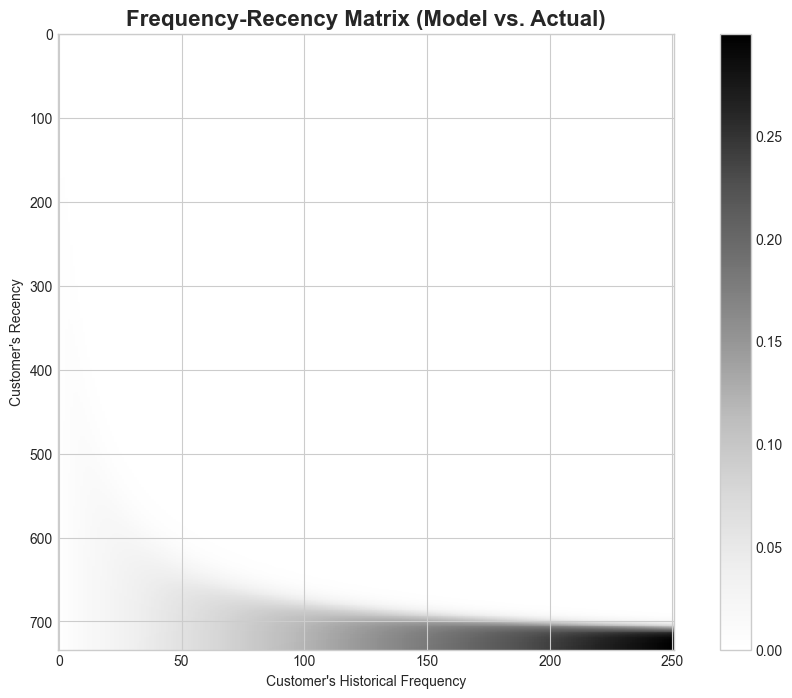

In [13]:
# Fit the BG/NBD Model
# Instantiate the BG/NBD model
bgf = BetaGeoFitter(penalizer_coef=0.0)

# Fit the model to our summary data
bgf.fit(ltv_summary['frequency'], ltv_summary['recency'], ltv_summary['T'])

print("BG/NBD Model Fitted")
print(bgf)

#Visualize Model's Performance
plt.figure(figsize=(12, 8))
plot_frequency_recency_matrix(bgf)
plt.title('Frequency-Recency Matrix (Model vs. Actual)', fontsize=16, fontweight='bold')
plt.show()

In [14]:
#Fit the Gamma-Gamma Model
correlation = ltv_summary[['frequency', 'monetary_value']].corr().iloc[0, 1]
print(f"--- Checking Gamma-Gamma Model Assumption ---")
print(f"Correlation between frequency and monetary_value: {correlation:.4f}")

if abs(correlation) > 0.1:
    print("WARNING: The correlation is high. The Gamma-Gamma model might produce biased results.")
else:
    print("PASSED: Correlation is low enough to proceed.")

# Fit the model on the customers who have made repeat purchases
ggf = GammaGammaFitter(penalizer_coef=0.0)
ggf.fit(ltv_summary['frequency'],
        ltv_summary['monetary_value'])

print("\n--- Gamma-Gamma Model Fitted ---")
print(ggf)

--- Checking Gamma-Gamma Model Assumption ---
Correlation between frequency and monetary_value: 0.1191

--- Gamma-Gamma Model Fitted ---
<lifetimes.GammaGammaFitter: fitted with 4148 subjects, p: 1.54, q: 4.41, v: 721.05>


### Inference
1. The Gamma-Gamma model works best when the customers who purchase frequently are not necessarily the same customers who spend a lot per transaction. In our data, there is a weak positive correlation, meaning customers who buy more often also tend to spend slightly more per purchase.
2. For this project, the correlation is low enough that we can proceed with the model, but we must acknowledge this slight bias.

In [15]:
# Calculate Final CLV

ltv_summary['clv'] = ggf.customer_lifetime_value(
    bgf,
    ltv_summary['frequency'],
    ltv_summary['recency'],
    ltv_summary['T'],
    ltv_summary['monetary_value'],
    time=12,  # Project CLV for the next 12 months
    discount_rate=0.01  
)

#Merge CLV data back into our main RFM dataframe
# Allows to see the predicted future value for each of segments
rfm_with_clv = rfm_final_df.join(ltv_summary['clv'])

rfm_with_clv['clv'].fillna(0, inplace=True)


print(" Top Customers by Predicted 12-Month CLV")
display(rfm_with_clv.sort_values(by='clv', ascending=False).head(20))

 Top Customers by Predicted 12-Month CLV


,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RF_Score,Segment,clv
Customer ID,,,,,,,,,
14911,1,391,226619.67,5,5,5,55,Champions,89013.837785
14096,6,16,40391.88,5,5,5,55,Champions,60838.759135
14646,10,142,153963.55,5,5,5,55,Champions,59823.923659
14156,3,156,121655.52,5,5,5,55,Champions,47515.790330
13089,3,201,88326.17,5,5,5,55,Champions,34805.429164
18102,7,142,87330.28,5,5,5,55,Champions,33784.711578
17511,12,58,76640.64,5,5,5,55,Champions,29495.627644
15311,2,206,68964.36,5,5,5,55,Champions,27078.754881
14298,4,82,68513.63,5,5,5,55,Champions,26679.893688


### Inference
The output clearly shows that customers identified as "Champions" and "Loyal Customers" have, by far, the highest predicted Customer Lifetime Value. This confirms that the RFM segmentation is a strong leading indicator of future value. The CLV model gives us a forward-looking financial metric that we can now use to justify investing more in retaining these specific customers.

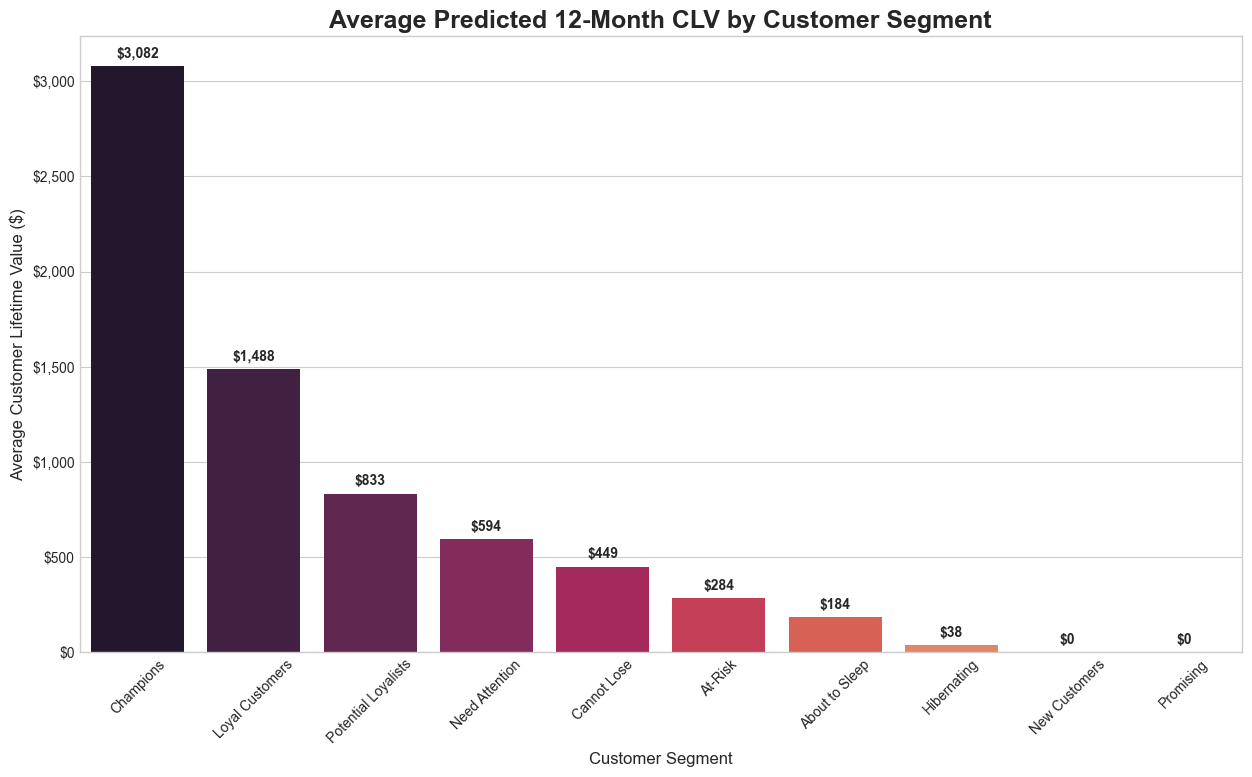

In [16]:
# Visualize Average CLV by Segment

# Group by segment and calculate the mean CLV
segment_clv = rfm_with_clv.groupby('Segment')['clv'].mean().sort_values(ascending=False)

# Create the bar plot
plt.figure(figsize=(15, 8))
ax = sns.barplot(x=segment_clv.index, y=segment_clv.values, palette="rocket")

#Formatting and data labels
ax.set_title('Average Predicted 12-Month CLV by Customer Segment', fontsize=18, fontweight='bold')
ax.set_xlabel('Customer Segment', fontsize=12)
ax.set_ylabel('Average Customer Lifetime Value ($)', fontsize=12)
ax.tick_params(axis='x', rotation=45)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'${y:,.0f}'))

# Add data labels on top of each bar
for p in ax.patches:
    ax.annotate(f"${p.get_height():,.0f}", 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points',
                fontweight='bold')

plt.show()

### Inference from Segment CLV Analysis
This analysis provides a powerful, forward-looking valuation of our customer base. It tells us not just who was valuable in the past, but who is predicted to generate the most value over the next 12 months.

1. The Elite Tier: The "Champions" segment is in a class of its own. A single Champion is predicted to be worth more than twice as much as a "Loyal Customer" ($ 3082 vs. $1488). This justifies a disproportionate investment in retaining this small but mighty group.
2. The Core Engine: The "Loyal Customers" are the high-value backbone of the business. While not as elite as Champions, they represent a significant and reliable source of future revenue.
3. The "Zero CLV" Insight: The most critical business insight here is the $0 CLV for "New Customers" and "Promising". This does not mean they are worthless; it means their future value is entirely unrealized and unpredictable until they make a second purchase. This quantitatively proves that the single most important marketing action is to convert a new customer into a repeat customer.

Strategic Conclusion: The company's future financial health depends on two things: retaining its "Champions" and "Loyal Customers" at all costs, and effectively moving "New Customers" to a segment with a predictable, non-zero CLV.

In [17]:
# Save file ready for modeling
rfm_with_clv.to_csv('../data/processed/modeling.csv', index= True)